In [1]:
from utils import *
from app import *

In [2]:
source, dest, lon_bike, lat_bike, dtime_bike = get_directions('Holländische Reihe 15, Hamburg',
                                                              'Bundesstrasse 53, Hamburg', 'cycling')

In [172]:
df = pd.DataFrame({'lons': lon_bike, 
                               'lats': lat_bike, 
                               'dtime': dtime_bike.seconds.values,
                               'source': source,
                               'destination': dest})
fig = generate_map_plot(df)
fig.add_trace(go.Densitymapbox(lat=lat_to_plot, lon=lon_to_plot, z=rain_to_plot,
                                 radius=1, showscale=False, hoverinfo='skip', zmin=1))

In [3]:
lon_radar, lat_radar, time_radar, dtime_radar, rr = get_radar_data_cached()

In [91]:
lon_bike.min()- 1

8.930301

In [122]:
indices = (lon_radar.ravel() > (lon_bike.min() - 1)) & (lon_radar.ravel() < (lon_bike.max() +1)) &\
(lat_radar.ravel() > (lat_bike.min() - 1)) & (lat_radar.ravel() < (lat_bike.max() +1))

In [133]:
indices = (lon_radar > (lon_bike.min() - 1)) & (lon_radar < (lon_bike.max() +1)) &\
(lat_radar > (lat_bike.min() - 1)) & (lat_radar < (lat_bike.max() +1))

In [140]:
lon_to_plot = lon_radar[indices]
lat_to_plot = lat_radar[indices]
rain_to_plot = rr[0, indices]

In [149]:
proj_defs = {
    'euratl':
    {
        'extents':[-23.5, 45, 29.5, 70.5],
        'resolution': '50m',
        'regions':False
    },
    'it':
    {
        'extents':[6, 19, 36, 48],
        'resolution': '10m',
        'regions':True
    },
    'de':
    {
        'extents':[5, 16, 46.5, 56],
        'resolution': '10m',
        'regions':True
    },
        'ham':
    {
        'extents':[9.65, 10.5, 53, 54],
        'resolution': '10m',
        'regions':True
    }
}

import matplotlib.pyplot as plt

def get_projection_cartopy(plt, projection="euratl", compute_projection=False):
    '''Retrieve the projection using cartopy'''
    if compute_projection:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        import cartopy.io.shapereader as shpreader

        proj_opts = proj_defs[projection]

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(proj_opts['extents'], ccrs.PlateCarree())
        ax.coastlines(resolution=proj_opts['resolution'])
        ax.add_feature(cfeature.BORDERS.with_scale(proj_opts['resolution']))

        if proj_opts['regions']:
            states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=proj_opts['resolution'],
                facecolor='none')
            ax.add_feature(states_provinces, edgecolor='black', alpha=.5)

        return(ax)
    else:
        return(add_background(plt, projection, image=projection+"_background.png"))

def get_projection(plt, bounds):
    '''Retrieve the projection using cartopy'''
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cartopy.io.shapereader as shpreader


    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bounds, ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', alpha=.5)

    return(ax)

/Users/thd5tt/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



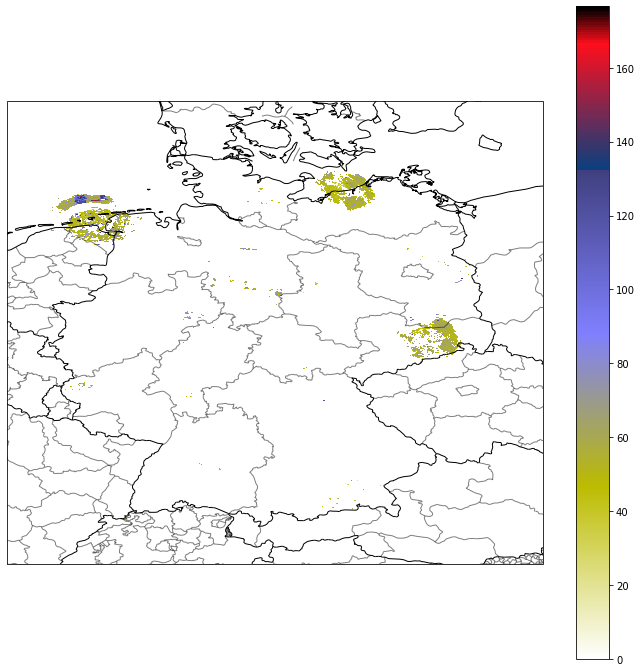

In [155]:
fig = plt.figure(figsize=(12, 12))

lon_radar, lat_radar, time_radar, dtime_radar, rr = get_radar_data_cached()

ax = get_projection_cartopy(plt, projection='de', compute_projection=True)

plt.pcolormesh(lon_radar, lat_radar, rr[0], cmap='gist_stern_r')

plt.colorbar()